# AIAP 22 Technical Assessment - Exploratory Data Analysis for Phishing Dataset 


## Table of Contents<a id='0'></a>

### [1. Introduction](#1)

- Problem Statement
- Data Description

### [2. Data Acquisition and Loading](#2)

- Notebook Setup
- Load Data


### [3. Data Cleaning and Processing](#3)

- Rename Columns and Convert Types
- Drop Duplicates
- Handling Unusual Values and Ranges
- Handling Null Values

### [4. Data Analysis and Visualisation](#4)
- Analyses of Impact of Categorical Variables on Activity Level
- Analyses of Impact of Numerical Variables on Activity Level

### [5. Conclusions](#5)
- Insights
- Next Steps
---

## 1. Introduction<a id='1'></a>
[Return to Table of Contents](#0)

### Problem Statement
 



### Data Description

---

## 2. Data Acquisition and Loading<a id='2'></a>
[Return to Table of Contents](#0)

### 2a. Notebook Setup

In [1]:
# Load necessary packages for data ingestion, cleaning EDA 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import normaltest, chi2_contingency, ttest_ind, f_oneway
from sqlalchemy import create_engine, MetaData, Table, inspect
import requests
import sqlite3
from pathlib import Path
from pyampute.exploration.mcar_statistical_tests import MCARTest

# Set Pandas options

%matplotlib inline
plt.rcParams['figure.figsize'] = [25,10]
plt.rcParams['font.size'] = 24
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 120)

### 2b. Load Data

In [2]:

DATA_URL = "https://techassessment.blob.core.windows.net/aiap22-assessment-data/phishing.db"
DATA_DIR = Path("data")
DB_PATH = DATA_DIR / "phishing.db"

DATA_DIR.mkdir(parents=True, exist_ok=True)

def download_database(force_refresh=False):
    """Download the phishing SQLite DB unless a cached copy exists (or refresh requested)."""
    if DB_PATH.exists() and not force_refresh:
        print(f"Using cached database at {DB_PATH.resolve()}")
        return DB_PATH

    print("Downloading phishing.db ...")
    response = requests.get(DATA_URL, timeout=30)
    response.raise_for_status()
    DB_PATH.write_bytes(response.content)
    print(f"Saved database to {DB_PATH.resolve()}")
    return DB_PATH

db_path = download_database()
db_path


Using cached database at C:\Users\epist\OneDrive\Desktop\aiap-22-project\data\phishing.db


WindowsPath('data/phishing.db')

In [3]:
# Load dataset using Sqlalchemy

engine = create_engine('sqlite:///data/phishing.db')
conn = engine.connect()

# Reflect data
metadata = MetaData()
metadata.reflect(bind=engine)

# Check what tables exist
insp = inspect(engine)
tables = insp.get_table_names()
print('\033[1m'+ "Tables in DB: " + '\033[0m', tables) 


Tables in DB:  ['phishing_data']


In [4]:
# Convert table(s) in db to pandas df:
df = pd.read_sql_table('phishing_data', con=engine)

### 2c. Basic Inspection

In [5]:
# Show first 5 rows of the dataframe for visual inspection

df.head()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,1,769.00,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,2,720.00,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,3,198.00,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,4,972.00,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1


In [6]:
# Print index, shape, data types

print('\033[1m'+ "Index: " + '\033[0m', df.index)
print('\033[1m' + "Number of rows: " + '\033[0m', df.shape[0])
print('\033[1m' + "Number of columns: " + '\033[0m', df.shape[1])
print('\033[1m' + "Data Types:" + '\033[0m\n' + str(df.dtypes))

Index:  RangeIndex(start=0, stop=10500, step=1)
Number of rows:  10500
Number of columns:  16
Data Types:
Unnamed: 0             int64
LineOfCode           float64
LargestLineLength      int64
NoOfURLRedirect        int64
NoOfSelfRedirect       int64
NoOfPopup              int64
NoOfiFrame             int64
NoOfImage              int64
NoOfSelfRef            int64
NoOfExternalRef        int64
Robots                 int64
IsResponsive           int64
Industry              object
HostingProvider       object
DomainAgeMonths        int64
label                  int64
dtype: object


In [7]:
# Check for null values

print('\033[1m' + "Total number of null values per column: "  + '\033[0m\n' + str(df.isnull().sum()))

# Check for number of unique values per column:

print('\033[1m' + "Total number of unique values per column: "  + '\033[0m\n' + str(df.nunique()))

Total number of null values per column: 
Unnamed: 0              0
LineOfCode           2355
LargestLineLength       0
NoOfURLRedirect         0
NoOfSelfRedirect        0
NoOfPopup               0
NoOfiFrame              0
NoOfImage               0
NoOfSelfRef             0
NoOfExternalRef         0
Robots                  0
IsResponsive            0
Industry                0
HostingProvider         0
DomainAgeMonths         0
label                   0
dtype: int64
Total number of unique values per column: 
Unnamed: 0           10500
LineOfCode            2875
LargestLineLength     4027
NoOfURLRedirect          2
NoOfSelfRedirect         2
NoOfPopup               26
NoOfiFrame              48
NoOfImage              308
NoOfSelfRef            533
NoOfExternalRef        463
Robots                   2
IsResponsive             2
Industry                11
HostingProvider         13
DomainAgeMonths        121
label                    2
dtype: int64


In [8]:
# List unique values for each categorical column (excluding one-hotted): 

for col in df.columns:
    if df[col].dtype == 'object':
        print('\033[1m' + "Unique Values of " + col + ": "  + '\033[0m\n' + str(df[col].unique()))


Unique Values of Industry: 
['Fashion' 'Education' 'Unknown' 'Manufacturing' 'eCommerce ' 'Non-profit'
 'Food' 'Government' 'eCommerce' 'Banking' 'Healthcare']
Unique Values of HostingProvider: 
['DreamHost' 'AWS' 'Google Cloud' 'GoDaddy' 'Freehostia' 'Bluehost'
 'Unknown Provider' 'Hostinger' 'Namecheap' 'InfinityFree' '000webhost'
 'Azure' 'HostGator']


In [9]:
# List summary statistics for each numerical column:

df.describe()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,DomainAgeMonths,label
count,10500.00,8145.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00
mean,5249.50,1376.95,11197.96,0.14,0.04,0.23,1.67,325.27,68.54,51.15,0.26,0.62,33.17,0.55
std,3031.23,5751.56,94168.98,0.34,0.19,5.70,5.02,30896.86,316.68,204.90,0.44,0.48,32.70,0.50
min,0.00,2.00,22.00,0.00,0.00,0.00,0.00,-35.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2624.75,88.00,180.75,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,5.00,0.00
50%,5249.50,620.00,1087.50,0.00,0.00,0.00,0.00,5.00,12.00,10.00,0.00,1.00,24.00,1.00
75%,7874.25,1452.00,8047.00,0.00,0.00,0.00,1.00,25.00,87.00,55.00,1.00,1.00,52.00,1.00
max,10499.00,418650.00,4336498.00,1.00,1.00,564.00,131.00,3166000.00,26596.00,12353.00,1.00,1.00,120.00,1.00


In [10]:
# Check for duplicate rows

df_dup = df[df.duplicated()]
df_dup.head()
print('\033[1m' + 'Total number of duplicated rows: ' + '\033[0m\n'  + str(len(df_dup)))


Total number of duplicated rows: 
0


In [11]:
# Categorize columns into categorical and numerical
# We categorize 'NoOfURLRedirect','NoOfSelfRedirect' as categoricals since they take binary values of either 1 or 0

cat_cols = ['NoOfURLRedirect','NoOfSelfRedirect', 'Robots', 'IsResponsive', 'Industry', 'HostingProvider', 'label']
num_cols = ['LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfSelfRef', 
            'NoOfExternalRef', 'DomainAgeMonths']

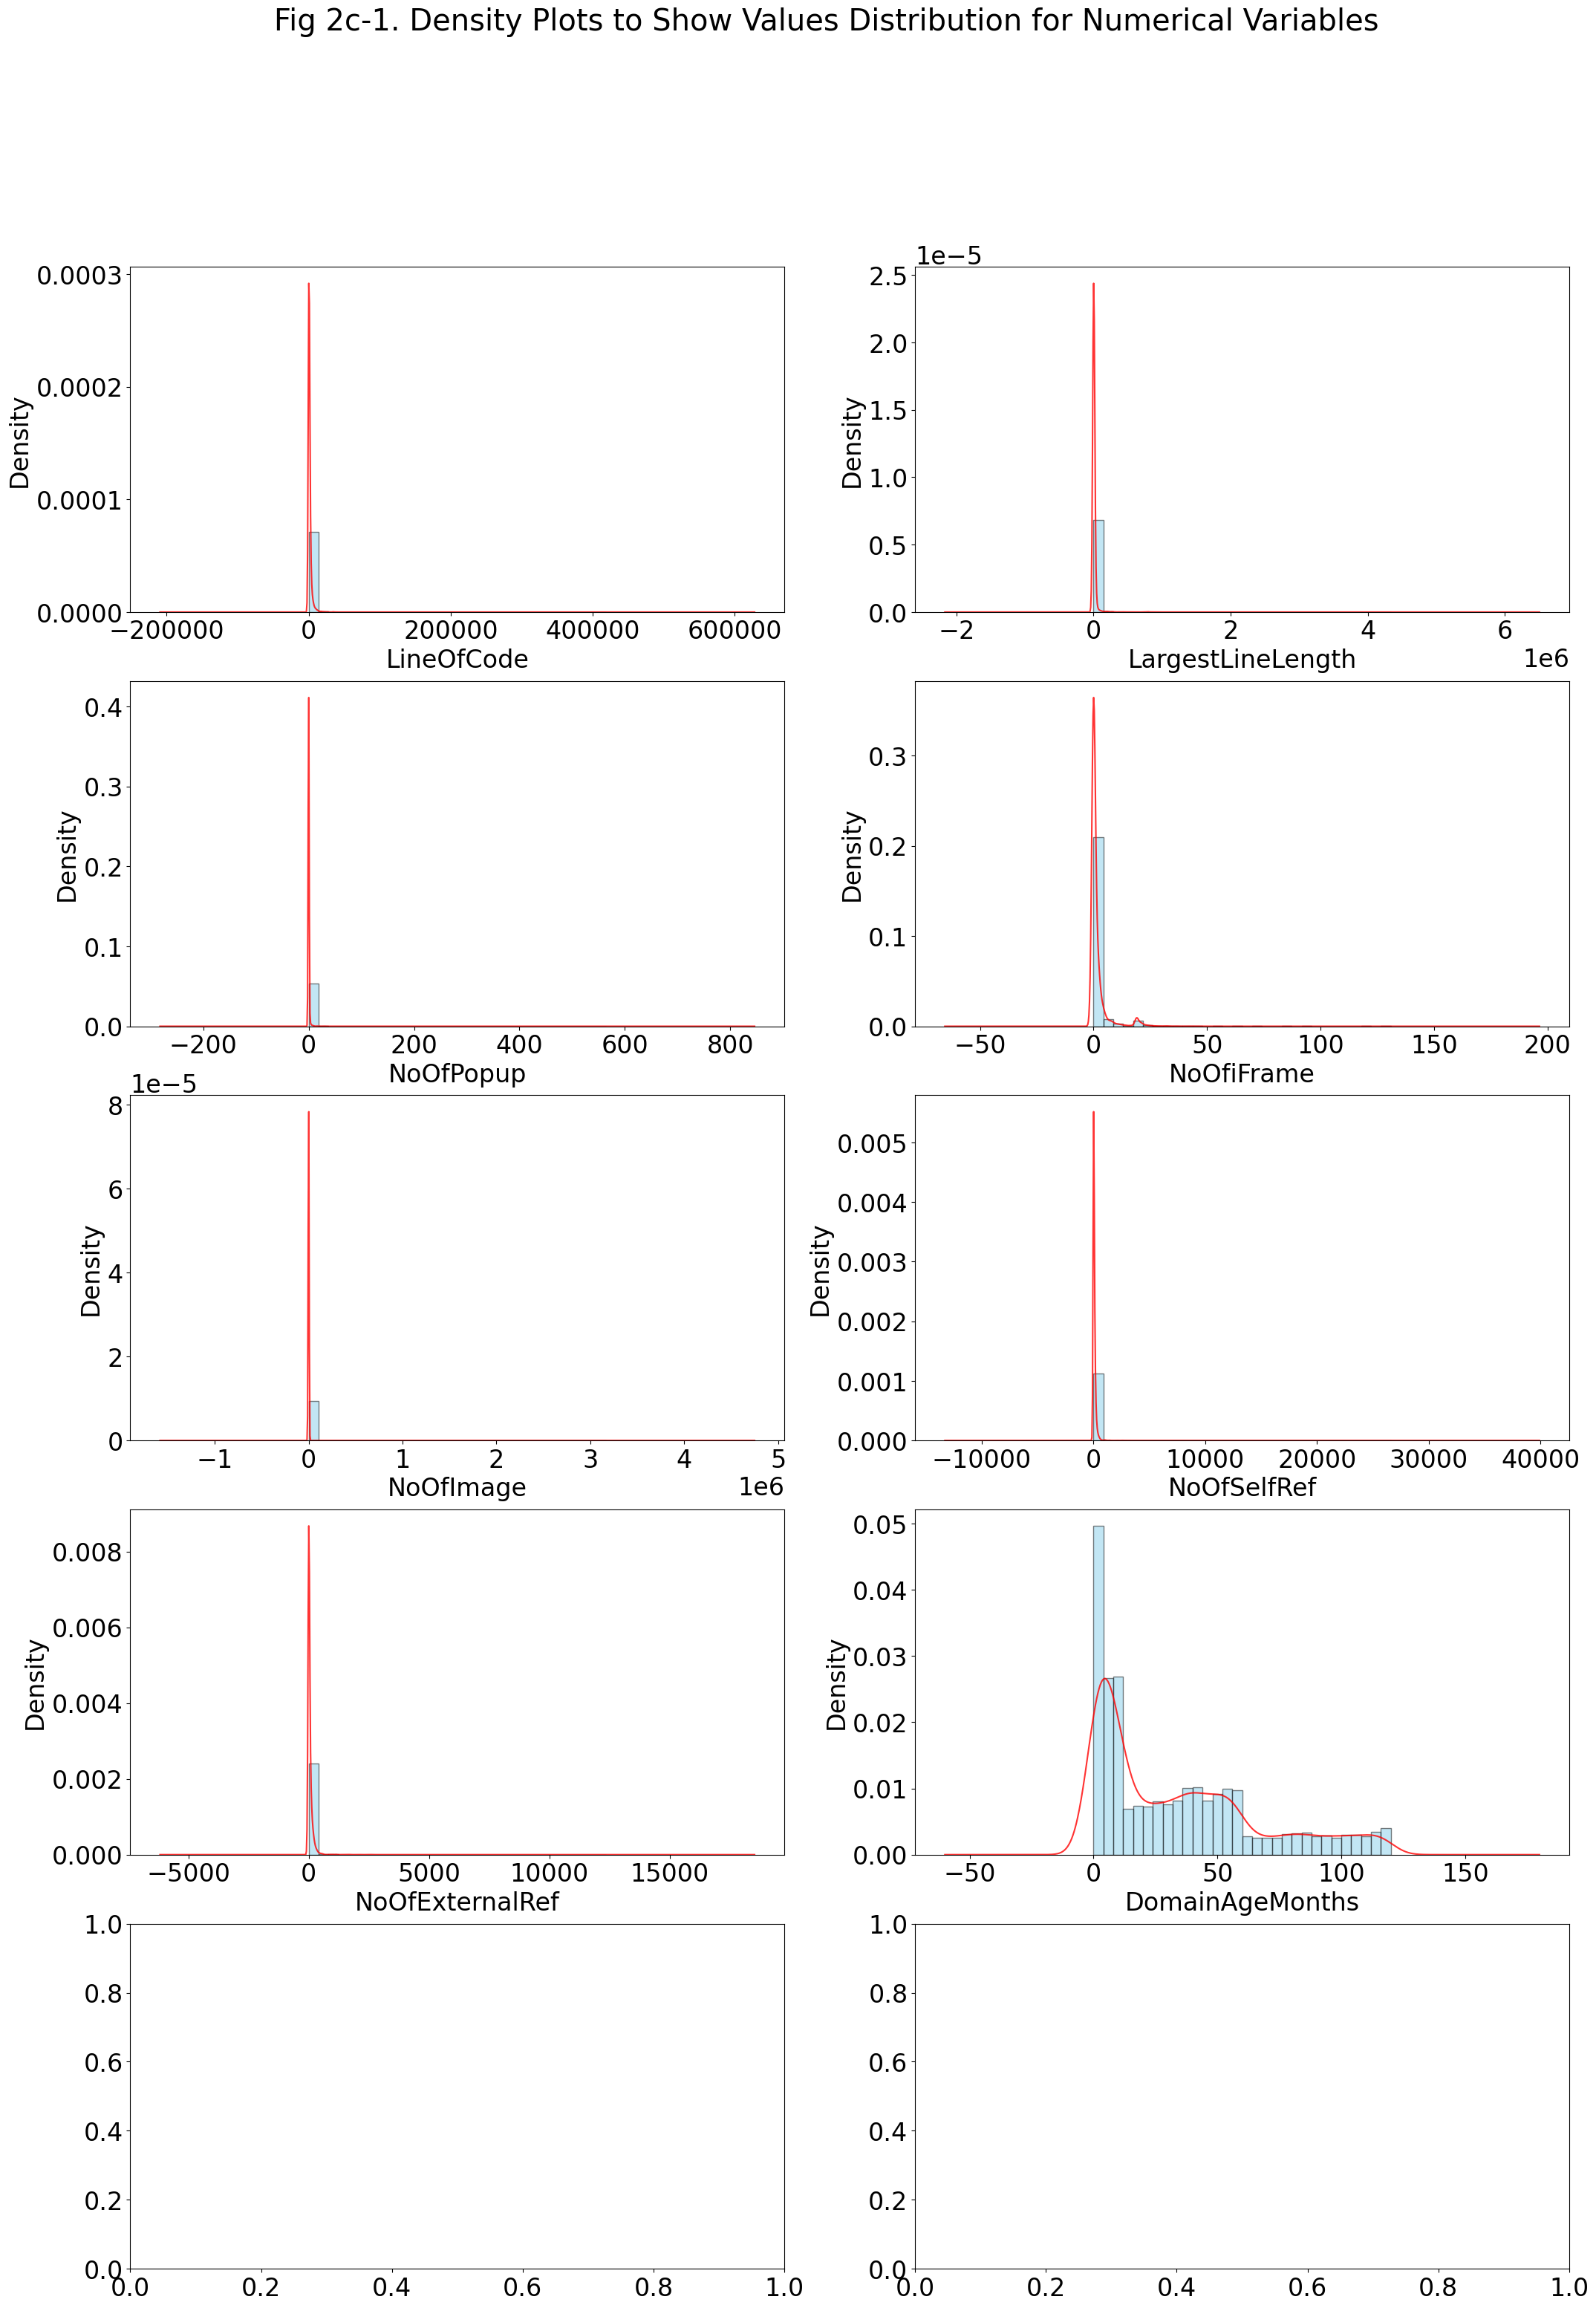

In [12]:
# Plot frequency distributions of each non-categorical continuous variable

plt.close('all') 

fig, axes = plt.subplots(5, 2, figsize=(25, 35))  # increase vertical figure size (height)
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(num_cols):
    df[col].plot(kind='hist', ax=axes[i], density=True, bins=30, alpha=0.5, color='skyblue', edgecolor='k')
    df[col].plot(kind='kde', ax=axes[i], alpha=0.8, color='red')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

plt.suptitle("Fig 2c-1. Density Plots to Show Values Distribution for Numerical Variables")
plt.show()

Basic inspection of the above suggests the following data cleaning steps are needed for EDA:

1. **Address Null Values**. About 20% of **LineofCode** contains null values that need to be either imputed or eliminated.
2. **Address Outliers/Unusual Values**: Diagnose and address potential outlier/unusual values in **NoOfiFrame**, **NoOfPopup**, **NoOfImage**, **NoOfSelfRef**, **NoOfExternalRef**. In particular, the negative values in **NoOfImage**.
3. **Clean up categorical labels**: strip whitespace from values in categorical labels e.g. "eCommerce" in **Industry**

---  

## 3. Data Cleaning and Processing<a id='3'></a>
[Return to Table of Contents](#0)

### 3a. Addressing Null Values

**LineOfCode** has a significant number of null values (~20% of the dataset). Given the large proportion, there is a need to determine how to inpute suitable values. We do this by analysing if there is a pattern to the nullness of **LineOfCode** and various categorical features.

In [13]:
# Run pairwise significance tests to determine if there are meaningful patterns in the dropped data

# Create a missingness indicator for LineOfCode
df["LineOfCodeIsMissing"] = df["LineOfCode"].isnull().astype(int)

print('\033[1m\n' + "Missingness Analysis for Categorical Data" + '\033[0m\n')

for j in cat_cols:
    # Cross-tabulate missingness of LineOfCode against the values of categorical column j
    contingency_table = pd.crosstab(df["LineOfCodeIsMissing"], df[j])

    try:
        chi2, p, _, _ = chi2_contingency(contingency_table)

        if p < 0.05:
            print(f"Missingness in LineOfCode is related to '{j}' based on p=value of {p} → Not MCAR")
        else:
            print(f"No relationship detected between missingness in LineOfCode and '{j}' → Possibly MCAR")
    except ValueError:
        print(f"Chi-square test failed for LineOfCode and '{j}' (possibly due to sparse data).")

print('\033[1m\n' + "Missingness Analysis for Numeric Data" + '\033[0m\n')

for j in num_cols:
    if j != "LineOfCode":
        group0 = df[df["LineOfCodeIsMissing"] == 0][j].dropna()
        group1 = df[df["LineOfCodeIsMissing"] == 1][j].dropna()

        # Ensure both groups have enough data
        if len(group0) > 1 and len(group1) > 1:
            stat, p = ttest_ind(group0, group1, equal_var=False)  # Welch's t-test
            if p < 0.05:
                print(f"Missingness in LineOfCode is related to '{j}' based on p=value of {p} → Not MCAR")
            else:
                print(f"No relationship detected between missingness in LineOfCode and '{j}'  → Possibly MCAR")
        
        else:
            print(f"Chi-square test failed for LineOfCode and '{j}' (possibly due to sparse data).")



Missingness Analysis for Categorical Data

No relationship detected between missingness in LineOfCode and 'NoOfURLRedirect' → Possibly MCAR
No relationship detected between missingness in LineOfCode and 'NoOfSelfRedirect' → Possibly MCAR
Missingness in LineOfCode is related to 'Robots' based on p=value of 2.731032635061394e-48 → Not MCAR
Missingness in LineOfCode is related to 'IsResponsive' based on p=value of 2.325464769941828e-99 → Not MCAR
Missingness in LineOfCode is related to 'Industry' based on p=value of 4.455411372603803e-33 → Not MCAR
Missingness in LineOfCode is related to 'HostingProvider' based on p=value of 5.58165205430259e-130 → Not MCAR
Missingness in LineOfCode is related to 'label' based on p=value of 0.0 → Not MCAR

Missingness Analysis for Numeric Data

No relationship detected between missingness in LineOfCode and 'LargestLineLength'  → Possibly MCAR
Missingness in LineOfCode is related to 'NoOfPopup' based on p=value of 0.007758915573728946 → Not MCAR
Missingne

In [14]:
# Impact of missingness on label

print("\033[1mMean label by LineOfCode missingness:\033[0m")
mean_label_by_missingness = df.groupby(df["LineOfCode"].isnull())["label"].mean()
print(mean_label_by_missingness)


Mean label by LineOfCode missingness:
LineOfCode
False   0.71
True    0.00
Name: label, dtype: float64


Given that the various MCAR pairwise tests indicated that missingness was not random, and that the impact of missingness on the label is quite stark, we should not drop the column at this stage. Instead, we will include a flag to indicate the missingness in LineOfCode and impute 0 to the missing values.

In [15]:
# Create missingness flag and fill LineofCode nans with 0

df["LineOfCodeIsMissing"] = np.where(df.LineOfCode.isna(), 1, 0)
df.LineOfCode = df.LineOfCode.fillna(0)

In [16]:
# Check no nulls

df.isna().sum()

Unnamed: 0             0
LineOfCode             0
LargestLineLength      0
NoOfURLRedirect        0
NoOfSelfRedirect       0
NoOfPopup              0
NoOfiFrame             0
NoOfImage              0
NoOfSelfRef            0
NoOfExternalRef        0
Robots                 0
IsResponsive           0
Industry               0
HostingProvider        0
DomainAgeMonths        0
label                  0
LineOfCodeIsMissing    0
dtype: int64

### 3b. Unusual and Outlier Values

**NoOfiFrame**, **NoOfPopup**, **NoOfImage**, **NoOfSelfRef**, **NoOfExternalRef** all have values that are significantly outside the standard deviation ranges of their distributions. We need to take a closer look to determine if these values can be dropped.

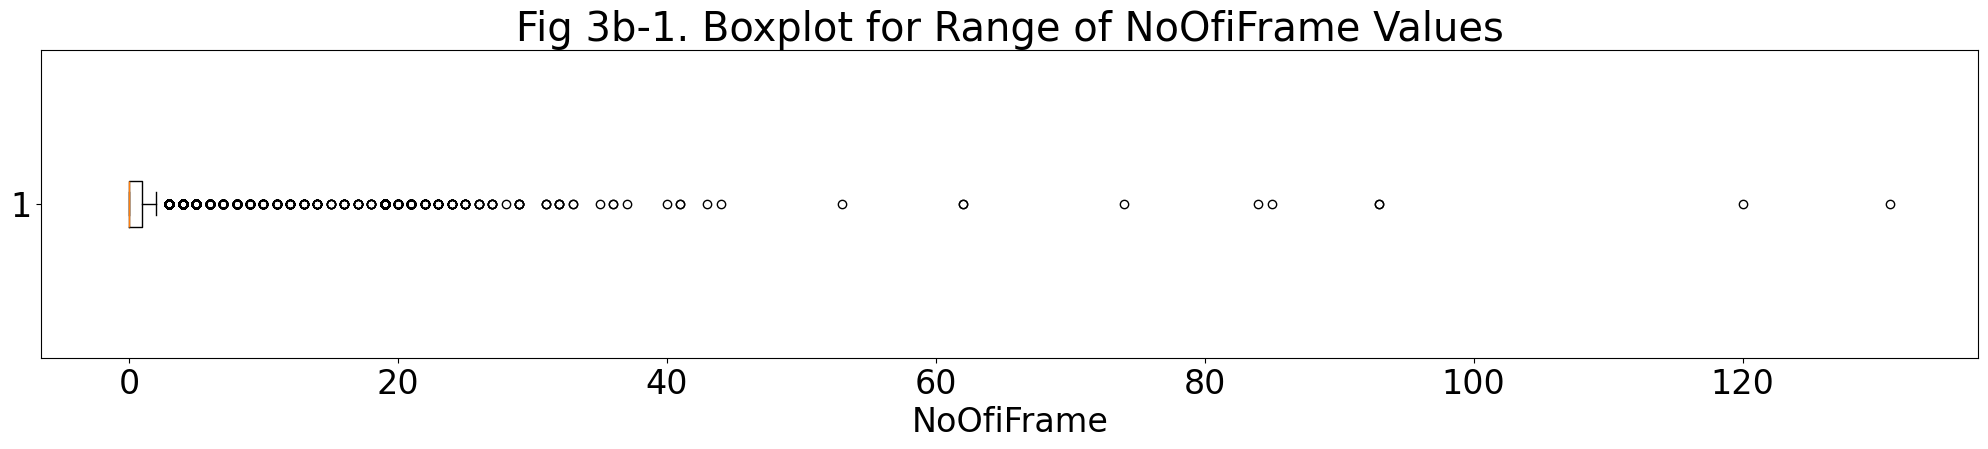

In [17]:
# Inspect range of NoOfiFrame values

plt.figure(figsize=(25, 4))
plt.boxplot(df["NoOfiFrame"].dropna(), vert=False)
plt.title("Fig 3b-1. Boxplot for Range of NoOfiFrame Values")
plt.xlabel("NoOfiFrame")
plt.show()


**Analysis of NoOfiFrame**: the distribution clusters mainly around 0-1 iFrames per page, with a number of right-skewed outliers. Internet research suggests that sites with as many as hundreds of iFrames are possible and are indeed significantly associated with malicious sites, so we will take the presence of such outliers as useful signals for the model.

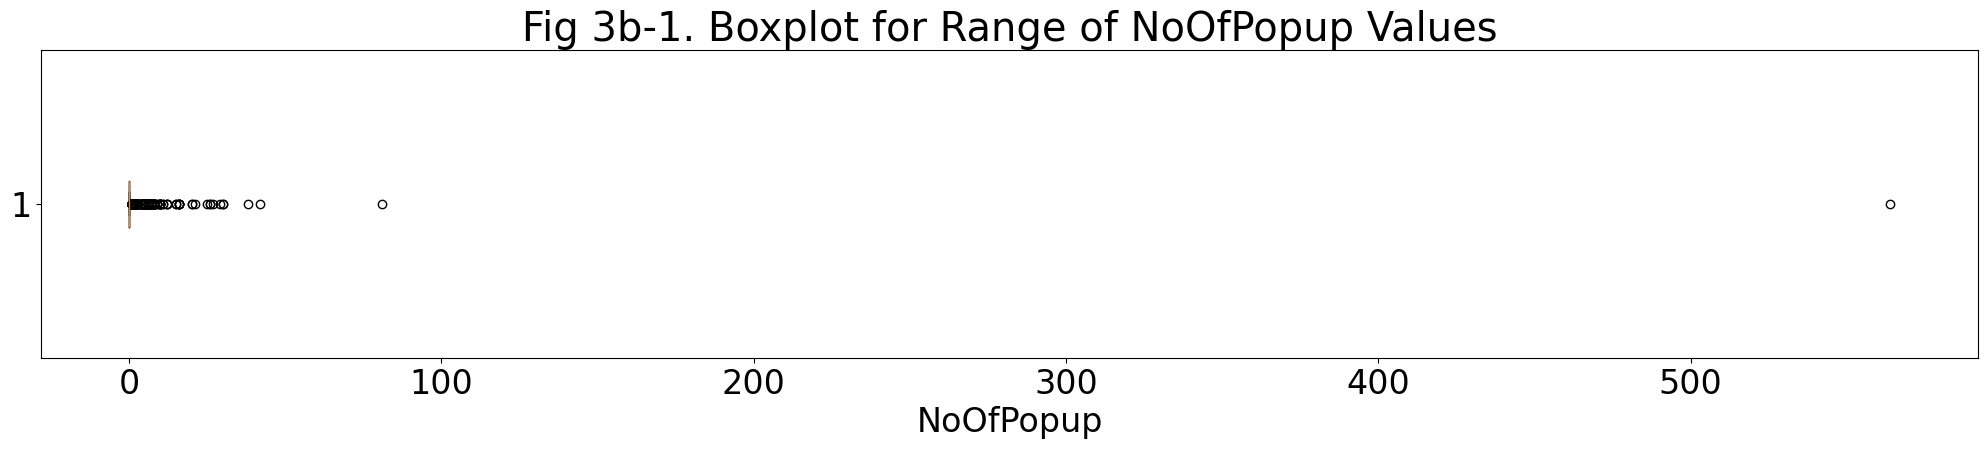

In [18]:
# Inspect range of NoOfPopup values

plt.figure(figsize=(25, 4))
plt.boxplot(df["NoOfPopup"].dropna(), vert=False)
plt.title("Fig 3b-1. Boxplot for Range of NoOfPopup Values")
plt.xlabel("NoOfPopup") 
plt.show()

**Analysis of NoOfPopup**: the distribution clusters mainly around 0-1 popups per page, with a number of right-skewed outliers. Internet research suggests that sites with as many as hundreds of attempted popups are also possible and are indeed significantly associated with malicious sites, so we will take the presence of such outliers as useful signals for the model.

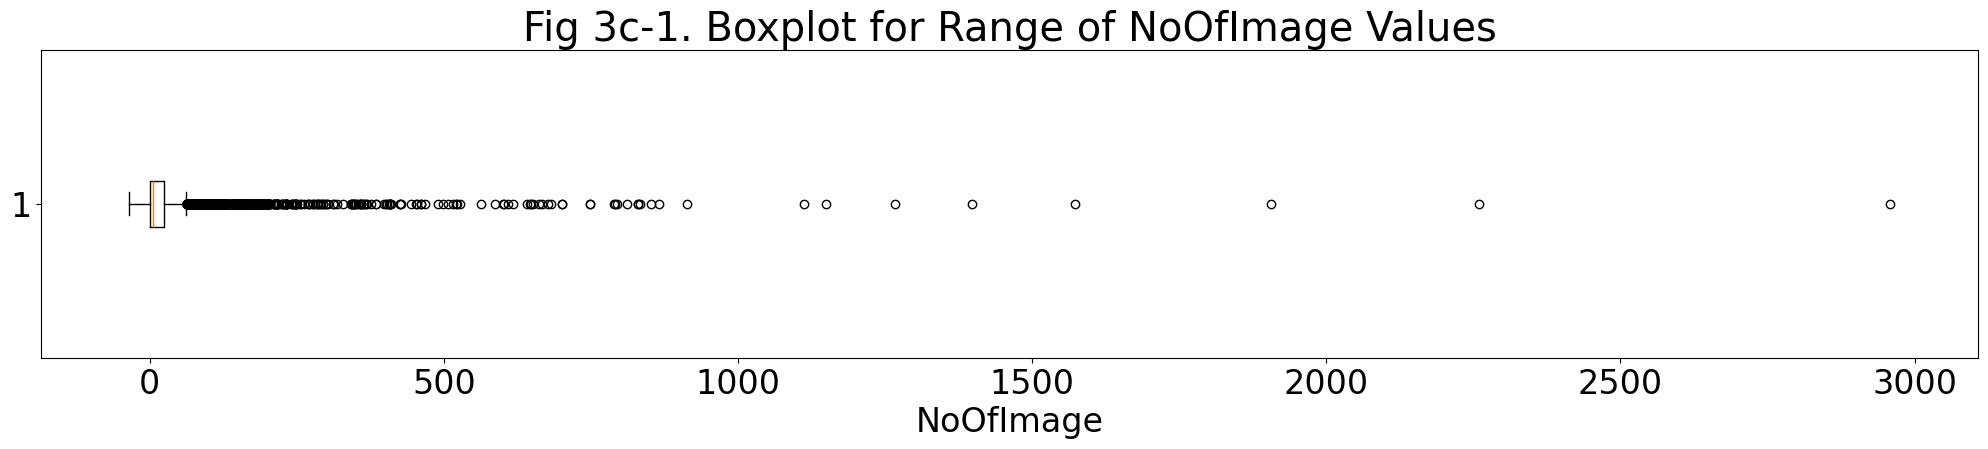

In [19]:
# Inspect range of NoOfImage values

plt.figure(figsize=(25, 4))
plt.boxplot(df[df["NoOfImage"] < 1000000]["NoOfImage"].dropna(), vert=False)
plt.title("Fig 3c-1. Boxplot for Range of NoOfImage Values")
plt.xlabel("NoOfImage")
plt.show()

In [20]:
df[df.NoOfImage < 0]["NoOfImage"].value_counts()

NoOfImage
-33    80
-31    79
-35    78
-32    71
-34    69
Name: count, dtype: int64

**Analysis of NoOfImage**: There are significant and extreme right-skewed outliers for NoOfImage, which could again serve as signals for the target (i.e. is a malicious site). However, we have also detected a fair number of negative values for this variable (~377). A quick check of summary statistics reveals that the subset of websites recorded as having < 0 images is much more likely to be labeled a spam site (~81%) than the population average (>55%). We cannot discount the possibility that the generation of negative values is a meaningful signal, so we will impute with median but add a flag to indicate the presence of negative values, and iterate the model as needed later.

In [21]:
df[df.NoOfImage < 0].describe()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,DomainAgeMonths,label,LineOfCodeIsMissing
count,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00
mean,5349.63,1538.17,8585.16,0.10,0.03,0.10,2.13,-32.99,115.18,84.79,0.53,0.92,49.28,0.81,0.11
std,3079.96,2267.17,15928.81,0.30,0.18,0.39,3.85,1.43,183.22,72.90,0.50,0.27,32.23,0.39,0.32
min,2.00,0.00,218.00,0.00,0.00,0.00,0.00,-35.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00
25%,2602.00,620.00,1336.00,0.00,0.00,0.00,0.00,-34.00,50.00,28.00,0.00,1.00,25.00,1.00,0.00
50%,5570.00,1080.00,5649.00,0.00,0.00,0.00,1.00,-33.00,86.00,68.00,1.00,1.00,45.00,1.00,0.00
75%,8015.00,1688.00,9381.00,0.00,0.00,0.00,2.00,-32.00,135.00,119.00,1.00,1.00,65.00,1.00,0.00
max,10488.00,25791.00,209757.00,1.00,1.00,3.00,36.00,-31.00,2950.00,500.00,1.00,1.00,119.00,1.00,1.00


In [22]:
# Create negative value flag and replace negative values with 0

df["NoOfImagesInvalid"] = np.where(df.NoOfImage < 0, 1, 0)
df["NoOfImage"] = df["NoOfImage"].apply(lambda x: x if x >= 0 else 0)

### 3c. Clean Up Labels

Strip whitespace from categorical labels.

In [23]:
for col in df.columns:
    if col in ["Industry", "HostingProvider"]:
        df[col] = df[col].str.strip()

## 4. Data Analysis and Visualisation<a id='4'></a>
[Return to Table of Contents](#0)

In [24]:
### Admin helper functions to help with viz

# Function to group dataset for stacked bar chart viz
def reformat_df(df, dep_col, indep_col, label_order):
    # Aggregate columns
    count_df = df.groupby([dep_col, indep_col]).size().unstack(fill_value=0)
    count_df = count_df[label_order]
    return count_df.div(count_df.sum(axis=1), axis=0)

def categorical_lift(df, dep_col, indep_col):
    base_rate = df[dep_col].mean()
    if base_rate == 0:
        raise ValueError("Lift undefined as base rate is zero.")
    out = (
        df
        .groupby(indep_col)[dep_col]
        .agg(
            n = "count",
            prob = "mean"
        )
        .reset_index()
    )
    out["lift"] = out["prob"]/base_rate
    print(out.sort_values("lift", ascending = False))

def chisq(df, dep_col, indep_col):
    contingency = df.groupby([dep_col, indep_col]).size().unstack(fill_value=0)
    chi2, p, dof, expected = chi2_contingency(contingency)
    min_expected = expected.min()
    if min_expected < 5:
        print(f'Warning: Some expected cell counts < 5 (minimum: {min_expected:.2f}), chi-squared results may not be robust.')    
    print(f' {indep_col}: {"Significant Association" if p < 0.05 else "No Significant Association"} for p-value of {p:.4f})')

def anova(df, cat_col, num_col):
    groups = [df[df[cat_col] == g][num_col].dropna() for g in df[cat_col].unique()]
    
    # Make sure there are at least 2 groups with data
    if len(groups) < 2 or any(len(g) == 0 for g in groups):
        print(f'{num_col}: Not enough data to run ANOVA.')
        return
    
    f_stat, p = f_oneway(*groups)
    print(f' {num_col}: {"Significant Association" if p <0.05 else "No Significant Association"} for p-value of {p:.4f})')



In [153]:
### Admin helper diagnostic function to test for: support, lift, dependence of feature on variable

def chi_sq_and_cramers_v(contingency):
    
    # Calculate chi2 p-score
    chi2, p, _, expected = chi2_contingency(contingency, correction = False)
    min_expected = expected.min()

    #Cramers V
    n = contingency.sum()
    r, k = contingency.shape
    if n == 0:
        v = np.nan
    else:
        v = np.sqrt((chi2 / n) / max(1, min(r - 1, k - 1)))

    return chi2, p, v, min_expected

def feature_diagnostic(
    df: pd.DataFrame,
    label: str,
    feature: str,
    *,
    classes = None,
    min_count: int = 30,
    lift_tol: float = 0.1,
    max_frac_outside: float = 0.20):

    #Build list of classes
    if classes is None:
        classes = list(pd.unique(df[label]))
    try:
        classes = sorted(classes)
    except Exception:
        pass

    #Base rate vector
    base_counts = df[label].value_counts().reindex(classes, fill_value = 0)
    n_total = int(base_counts.sum())
    base_p = (base_counts/n_total) if n_total > 0 else pd.Series([np.nan]*len(classes), index=classes)

    #Contingency table 
    c = pd.crosstab(df[feature], df[label])

    # chi2 score, p, and effect size
    chi2, p, v, min_expected = chi_sq_and_cramers_v(c.values)

    #Per-category support
    cat_n = c.sum(axis = 1).rename("n")
    #Filter to categories with enough support to list in details
    kept_cats = cat_n[cat_n >= min_count].index
    unkept_cats = cat_n[cat_n < min_count].index
    ct_kept = c.loc[kept_cats]

    # Per-category diagnostics

    detail = (
        ct_kept
        .stack()
        .rename("count")
        .reset_index()
        .rename(columns={feature: "category", label: "class"})
    )

    # Conditional probability P(y=class | category)
    # Compute from kept table for numerical stability
    denom = ct_kept.sum(axis=1).replace(0, np.nan)
    p_y_given_cat = (ct_kept.T / denom).T  # rows: category, cols: class
    p_long = (
        p_y_given_cat
        .stack()
        .rename("p_y_given_cat")
        .reset_index()
        .rename(columns={feature: "category", label: "class"})
    )

    detail = detail.merge(p_long, on=["category", "class"], how="left")

    # Base probability for each class
    detail["base_p"] = detail["class"].map(base_p)

    # Lift per class: P(y=c|cat)/P(y=c)
    detail["lift"] = detail["p_y_given_cat"] / detail["base_p"].replace(0, np.nan)

    # Add per-category n
    detail["n"] = detail["category"].map(cat_n)

    # Sort values for detail to rank by biggest deviations 
    detail = detail.sort_values(["category", "class"])

    # Per-category “distance from baseline” summaries
    per_category = (
        detail
        .groupby("category", as_index=False)
        .agg(
            n=("n", "first"),
            l1_dist=("p_y_given_cat", lambda s: np.nan),  # placeholder
            max_abs_lift_dev=("lift", lambda s: float(np.nanmax(np.abs(s - 1.0))) if len(s) else np.nan),
            frac_classes_outside_tol=("lift", lambda s: float(np.mean(np.abs(s - 1.0) > lift_tol)) if len(s) else np.nan),
        )
    )

    # Compute L1 distance properly using pivoted distributions
    dist_df = p_y_given_cat.copy()
    for cl in classes:
        dist_df[cl] = (dist_df[cl] - base_p[cl]).abs()
    l1 = dist_df.sum(axis=1).rename("l1_dist")
    per_category = per_category.merge(l1.reset_index().rename(columns={feature: "category"}), on="category", how="left")
    per_category["l1_dist"] = per_category["l1_dist_y"]
    per_category = per_category.drop(columns=["l1_dist_x", "l1_dist_y"])

    # Base-rate-ish heuristic across categories: most classes’ lifts near 1 for most categories
    if len(per_category) == 0:
        base_rate_tracker = np.nan
        frac_cats_outside = np.nan
        note = "no categories >= min_count"
    else:
        # Flag category as “outside” if ANY class deviates beyond tol (you can tighten/loosen this)
        cat_outside = per_category["max_abs_lift_dev"] > lift_tol
        frac_cats_outside = float(cat_outside.mean())
        base_rate_tracker = frac_cats_outside <= max_frac_outside
        note = ""

    summary = {
            "feature": feature,
            "total_n": n_total,
            "all_above_min_expected": bool(min_expected >= 5),
            "n_categories": int(c.shape[0]),
            "n_categories_used": int(len(ct_kept)),
            "kept_categories": str(kept_cats.values),
            "unkept_categories": str(unkept_cats.values),
            "n_classes": int(len(classes)),
            "chisq_p_value": float(p),
            "cramers_v": float(v), 
            "base_rate_tracker": base_rate_tracker,
            "frac_categories_outside_lift_tol": frac_cats_outside,
            "max_category_l1_dist": float(per_category["l1_dist"].max()) if len(per_category) else np.nan,
            "note": note,
    }

    return summary, detail


### Analyses of Impact of Categorical Variables on Label<a id='4-1'></a>
[Skip to Numeric Section](#4-2)

### 4a. General Distribution of Label

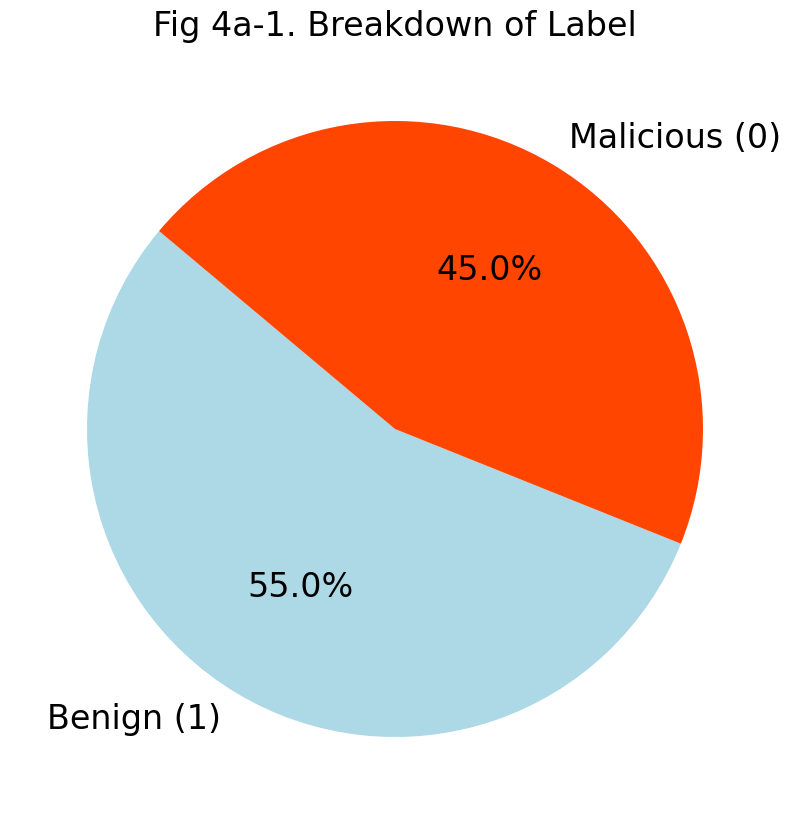

In [127]:
# Looking at label occurrence

plt.figure(figsize=(25,10))
plt.title("Fig 4a-1. Breakdown of Label", fontsize = 24)
plt.pie(
    df.label.value_counts(), 
    labels=[f'Malicious ({lbl})' if lbl == 0 else f'Benign ({lbl})' for lbl in df.label.value_counts().index], 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations**
- Fig 4a-1 indicates that about 45% of sites in the sample were classed as malicious (0), so the distribution is roughly equal (but also that this likely does not represent a randomized sample of sites). This likely represents a higher incidence of the positive class than the true prevalence of spam sites in the population, so the model and model evaluation will have to take this into account, i.e. the test and validation sets may need to be weighted to reflect the actual population distribution.  

### 4b. Impact of NoOfURLRedirect on Label

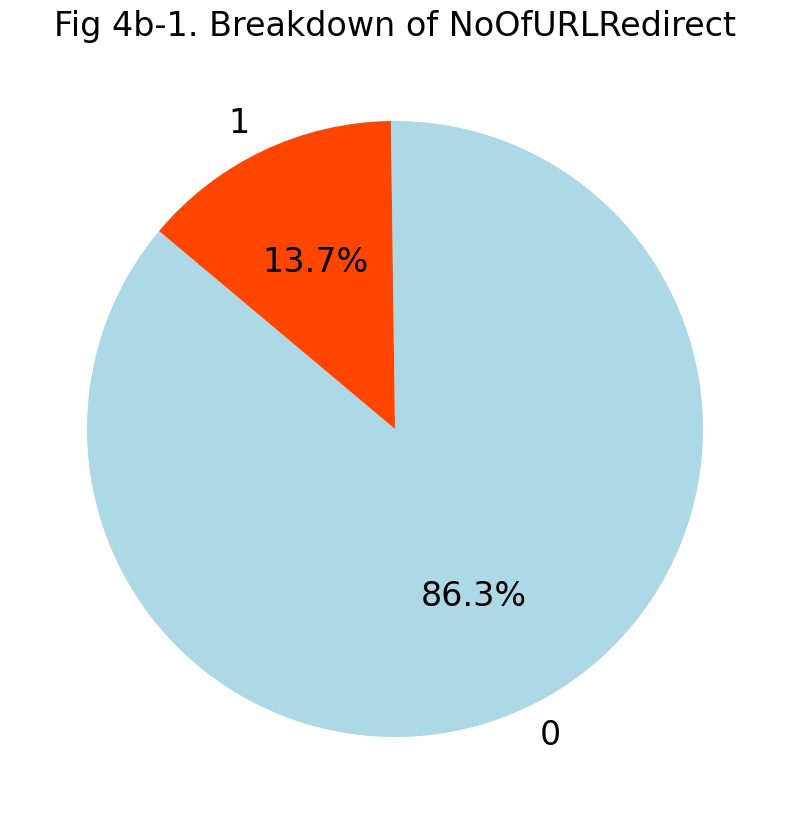

In [25]:
# Show NoOfURLRedirect breakdown

plt.figure(figsize=(25,10))
plt.title("Fig 4b-1. Breakdown of NoOfURLRedirect", fontsize = 24)
plt.pie(df.NoOfURLRedirect.value_counts(), labels = df.NoOfURLRedirect.value_counts().index, 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations:**

- About 14% of sites involved a URL redirect. Note that while the name of the column had suggested that this was a numeric variable, we treat it as categorical since the values are binary, and interpret as absence/presence of URL redirects.

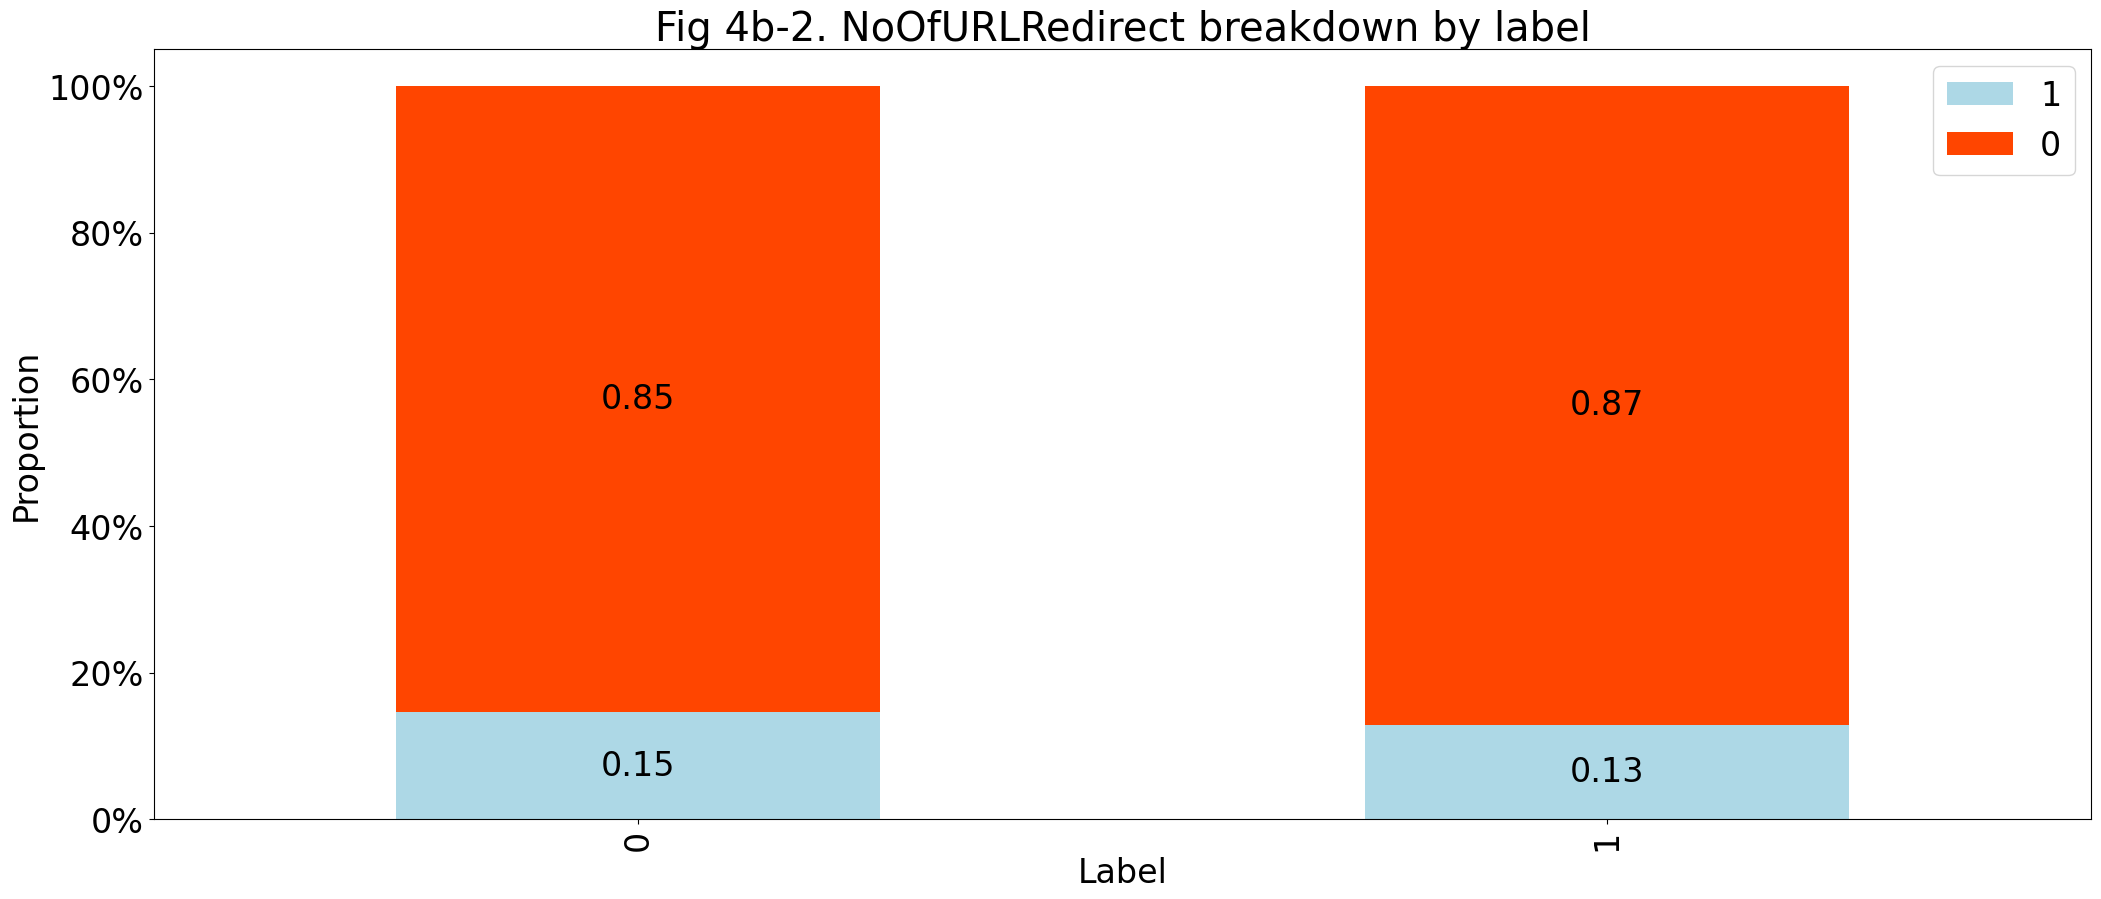

In [26]:
# Relationship between NoOfURLRedirect and label

df_4b1 = reformat_df(df, "label", "NoOfURLRedirect", [1, 0])
ax_4b1 = df_4b1.plot(kind='bar', stacked=True, color = ["lightblue", "orangered"])
plt.title('Fig 4b-2. NoOfURLRedirect breakdown by label')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend()

for c in ax_4b1.containers:
    ax_4b1.bar_label(c, label_type='center',  fmt= '%.2f')

plt.show()

In [154]:
# Chi-sqared test on NoOfURLRedirect and label
summary, detail = feature_diagnostic(df, "label", "NoOfURLRedirect")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  NoOfURLRedirect
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  0.013326221644266325
cramers_v :  0.02415284565763927
base_rate_tracker :  True
frac_categories_outside_lift_tol :  0.0
max_category_l1_dist :  0.06037193261705798
note :  
   category  class  count  p_y_given_cat  base_p  lift     n
0         0      0   4032           0.44    0.45  0.99  9064
1         0      1   5032           0.56    0.55  1.01  9064
2         1      0    689           0.48    0.45  1.07  1436
3         1      1    747           0.52    0.55  0.95  1436


**Observations**
- Fig 4b-2 shows that websites with URL redirects are 2% more likely to be flagged malicious than those without. 
- However, a diagnostic test of the feature indicates that while the chi2 test p-score is significant at 95% confidence, the strength of association between this feature and the label is weak (at Cramer's V ~ 0.02). None of the categories provide significant lift to the label, or deviates meaningfully from the baseline. 
- It is unlikely therefore that this feature on its own can be considered a strong predictor for the label. 

### 4c. Impact of NoOfSelfRedirect on Label

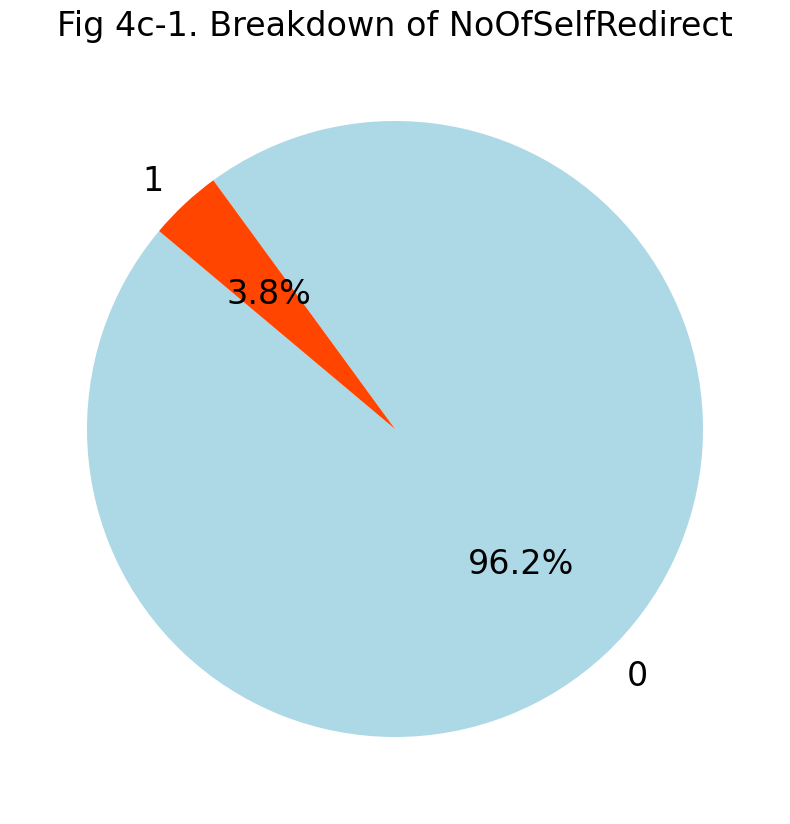

In [28]:
# Show NoOfURLRedirect breakdown

plt.figure(figsize=(25,10))
plt.title("Fig 4c-1. Breakdown of NoOfSelfRedirect", fontsize = 24)
plt.pie(df.NoOfSelfRedirect.value_counts(), labels = df.NoOfSelfRedirect.value_counts().index, 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations:**

- About 4% of sites displayed self-redirect behavior. Note that, similarly to NoOfURLRedirect, we interpret the column as a binary indicator of whether such behaviour was observed. 

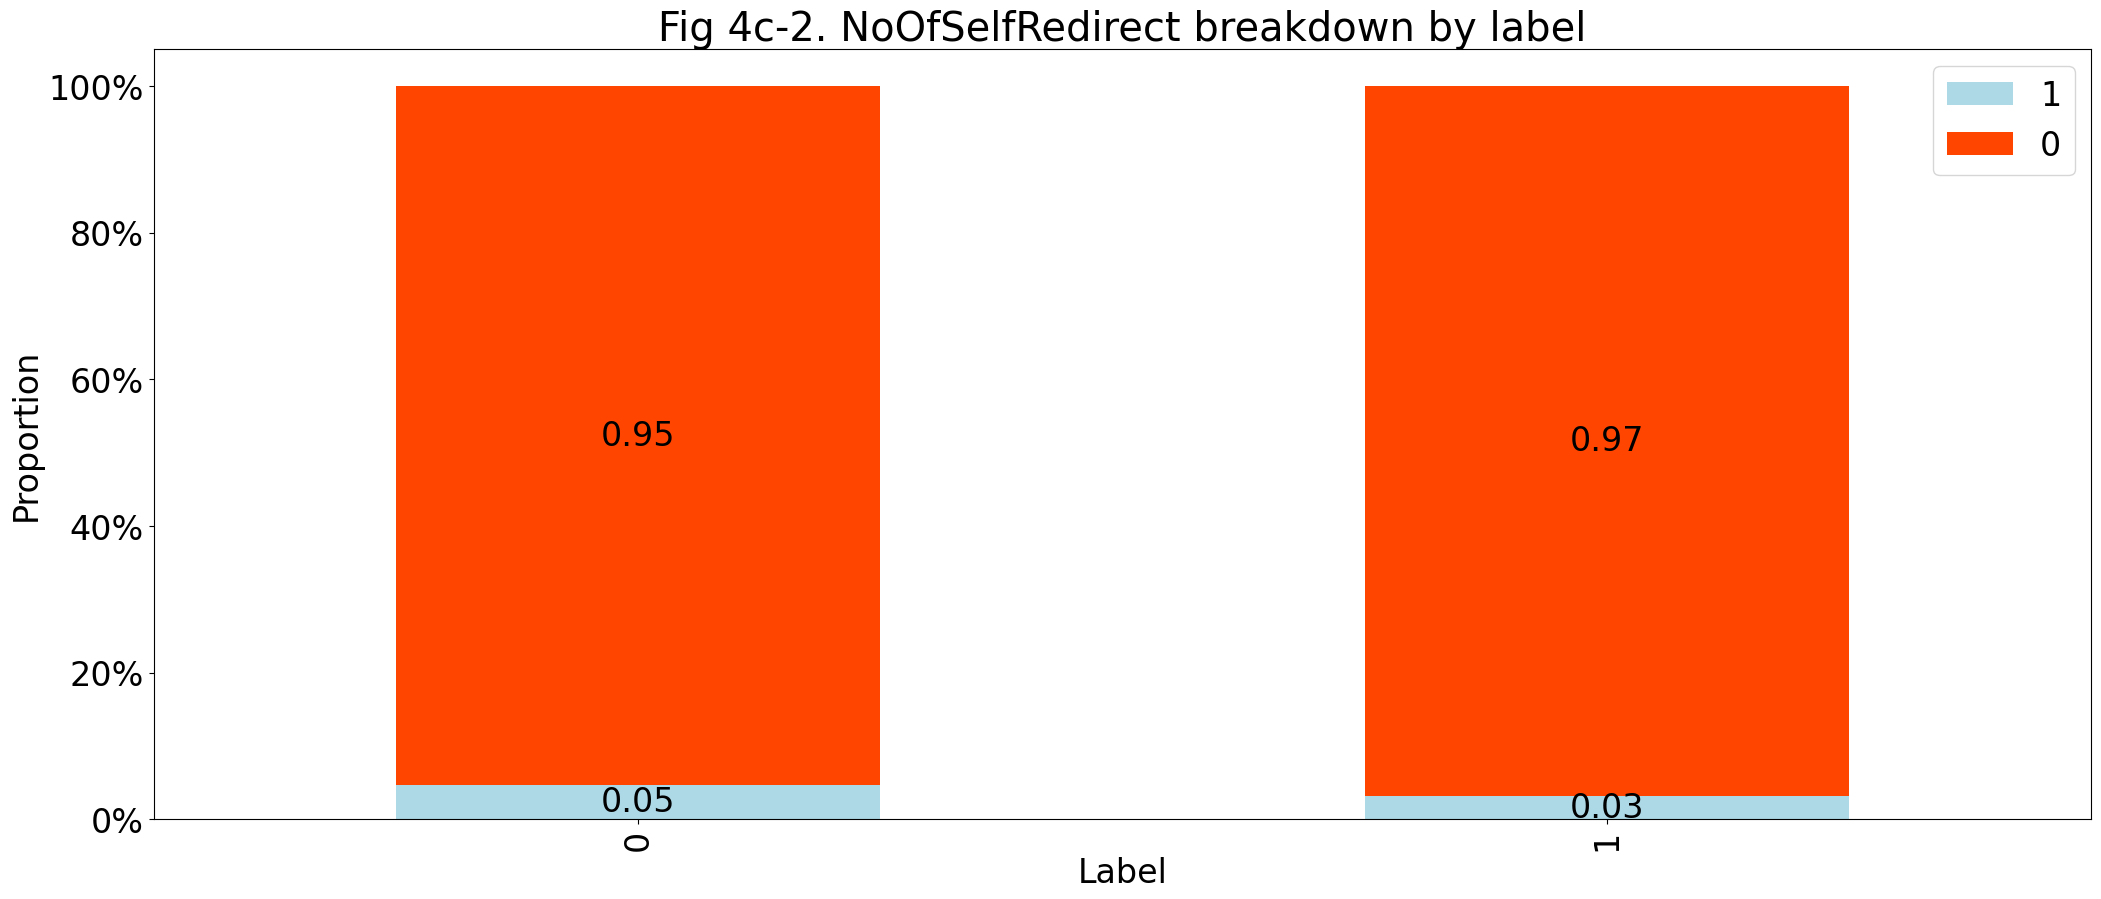

In [29]:
# Relationship between NoOfSelfRedirect and label

df_4c1 = reformat_df(df, "label", "NoOfSelfRedirect", [1, 0])
ax_4c1 = df_4c1.plot(kind='bar', stacked=True, color = ["lightblue", "orangered"])
plt.title('Fig 4c-2. NoOfSelfRedirect breakdown by label')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend()

for c in ax_4c1.containers:
    ax_4c1.bar_label(c, label_type='center',  fmt= '%.2f')

plt.show()

In [155]:
# Chi-sqared test on NoOfURLRedirect and label
summary, detail = feature_diagnostic(df, "label", "NoOfSelfRedirect")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  NoOfSelfRedirect
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  0.00013903446604427965
cramers_v :  0.037180618097002
base_rate_tracker :  False
frac_categories_outside_lift_tol :  0.5
max_category_l1_dist :  0.18492032060348895
note :  
   category  class  count  p_y_given_cat  base_p  lift      n
0         0      0   4502           0.45    0.45  0.99  10096
1         0      1   5594           0.55    0.55  1.01  10096
2         1      0    219           0.54    0.45  1.21    404
3         1      1    185           0.46    0.55  0.83    404


**Observations**
- Fig 4c-2 shows that again, websites with self redirects are slightly (2%) more likely to be flagged malicious than those without. 
- The diagnostic test shows that while chisq p is significant, the strength of association is low (Cramer's V ~ 0.03), though NoOfSelfRedirect = 1 results in some meaningful difference from the base rate. 
- In other words, there is an actual though weak association, though only provides signal in rare cases where there are website self-redirects. Therefore it can only serve as a meaningful signal in a small subset of situations. 

### 4d. Impact of Robots on Label

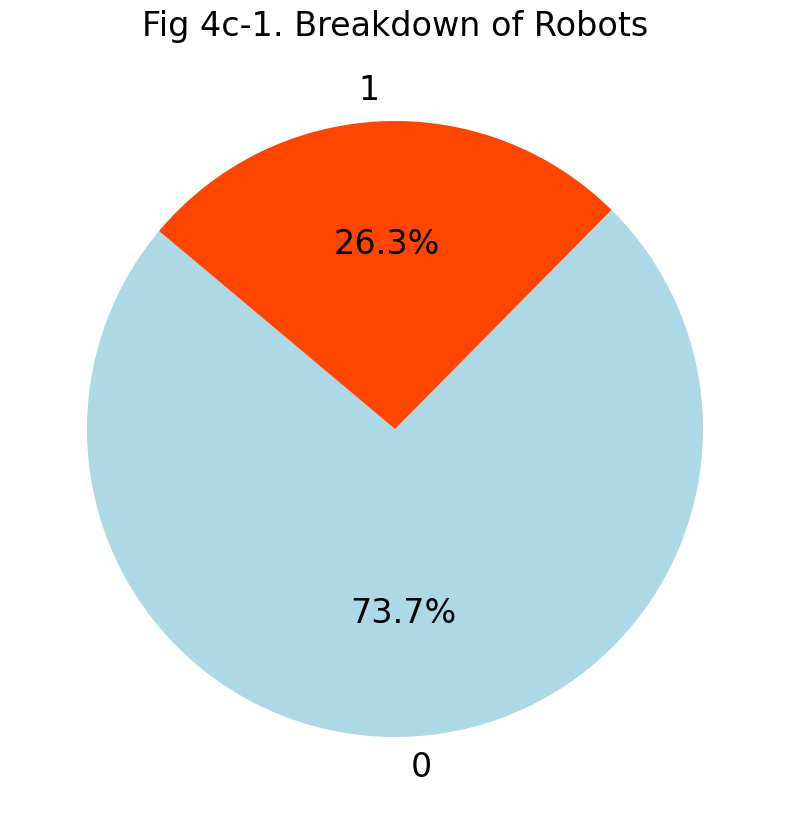

In [31]:
# Show Robots breakdown

plt.figure(figsize=(25,10))
plt.title("Fig 4d-1. Breakdown of Robots", fontsize = 24)
plt.pie(df.Robots.value_counts(), labels = df.Robots.value_counts().index, 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations:**
- About three quarters of sites had no robots.txt, which is a surprising proportion and probably not indicative of the population level distribution. 

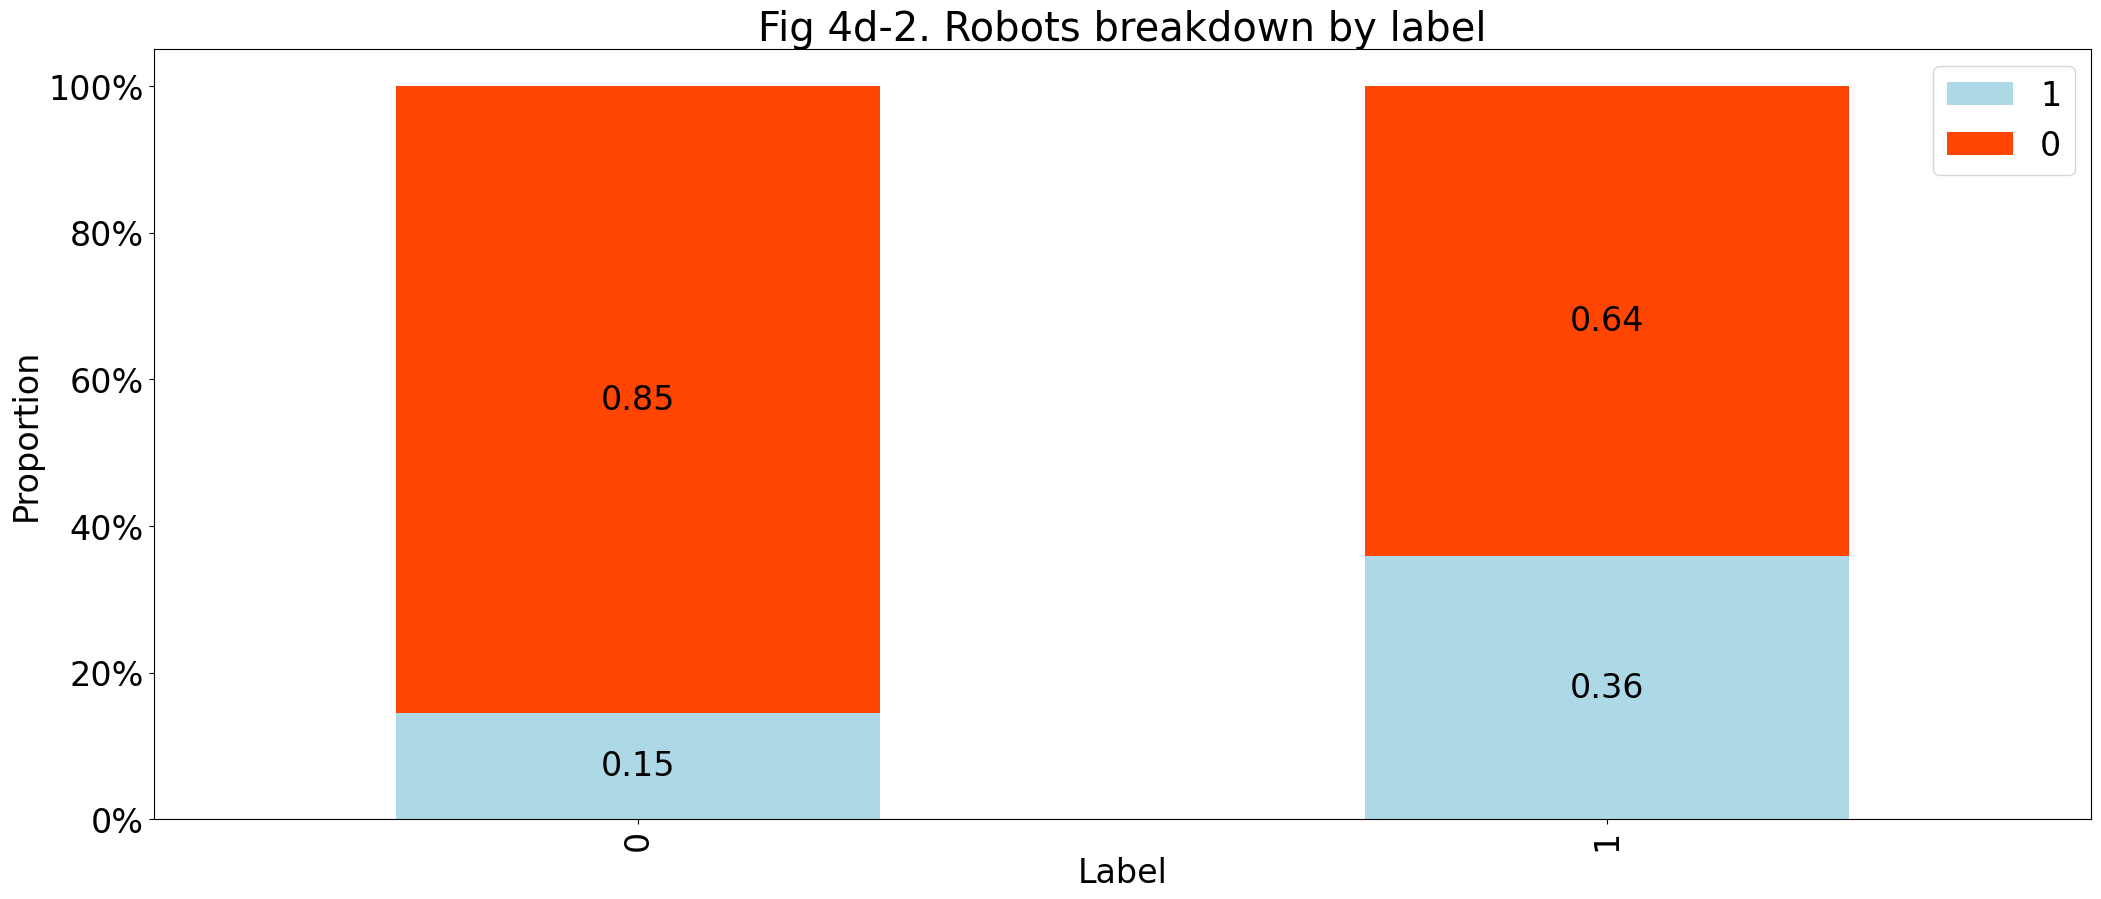

In [32]:
# Relationship between Robots and label

df_4d1 = reformat_df(df, "label", "Robots", [1, 0])
ax_4d1 = df_4d1.plot(kind='bar', stacked=True, color = ["lightblue", "orangered"])
plt.title('Fig 4d-2. Robots breakdown by label')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend()

for c in ax_4d1.containers:
    ax_4d1.bar_label(c, label_type='center',  fmt= '%.2f')

plt.show()

In [157]:
# Chi-sqared test on NoOfURLRedirect and label
summary, detail = feature_diagnostic(df, "label", "Robots")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  Robots
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  3.125655532584047e-135
cramers_v :  0.24153206000069039
base_rate_tracker :  False
frac_categories_outside_lift_tol :  1.0
max_category_l1_dist :  0.40231668995015607
note :  
   category  class  count  p_y_given_cat  base_p  lift     n
0         0      0   4035           0.52    0.45  1.16  7739
1         0      1   3704           0.48    0.55  0.87  7739
2         1      0    686           0.25    0.45  0.55  2761
3         1      1   2075           0.75    0.55  1.37  2761


**Observations**
- Fig 4d-2 suggests that the absence of a Robots.txt file is a statistically significant correlateion with a site being malicious; a much higher proportion of flagged malicious sites lack a robots.txt (85%) than in benign sites (64).
- The diagnostic test suggests that the presence and absence of Robots is likely a robust and stable predictor for the label, with a large association (Cramer's V ~ 0.24) and significant lift provided by both categories of Robots. In other words, both 1 and 0 values of Robots will change the distribution significantly from baseline.   
- One possible explanation is that creators of malicious sites don't bother generating robots.txt files since these files, which inform web crawlers what not to index, don't contribute to the main function of entrapping hapless victims

### 4e. Impact of IsResponsive on Label

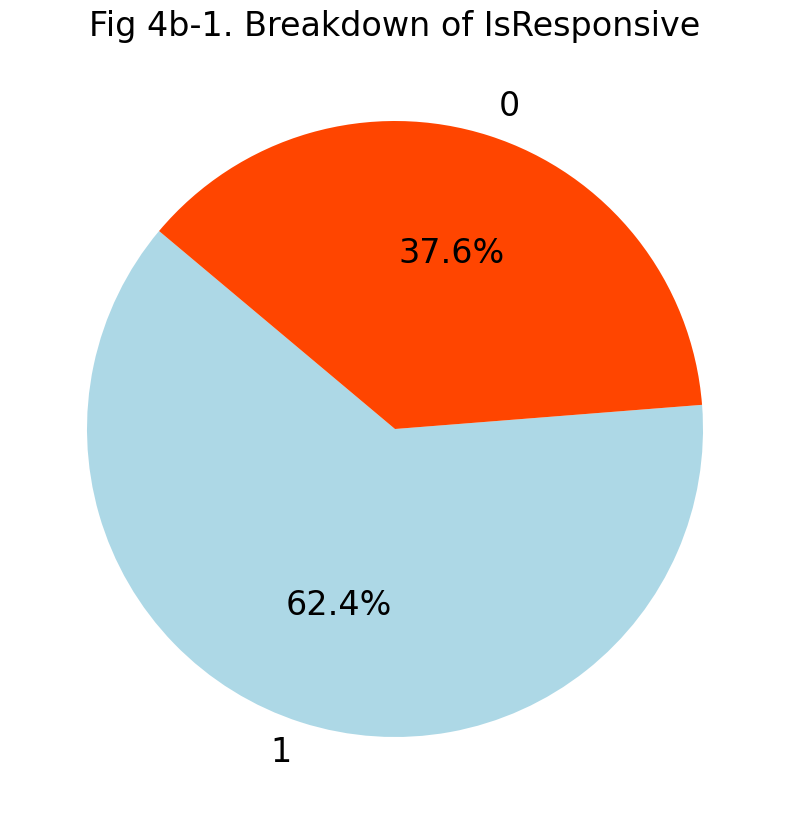

In [33]:
# Show IsResponsive breakdown

plt.figure(figsize=(25,10))
plt.title("Fig 4e-1. Breakdown of IsResponsive", fontsize = 24)
plt.pie(df.IsResponsive.value_counts(), labels = df.IsResponsive.value_counts().index, 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations**
- About 60% of sites are configured so that they can be adapted across different devices. 

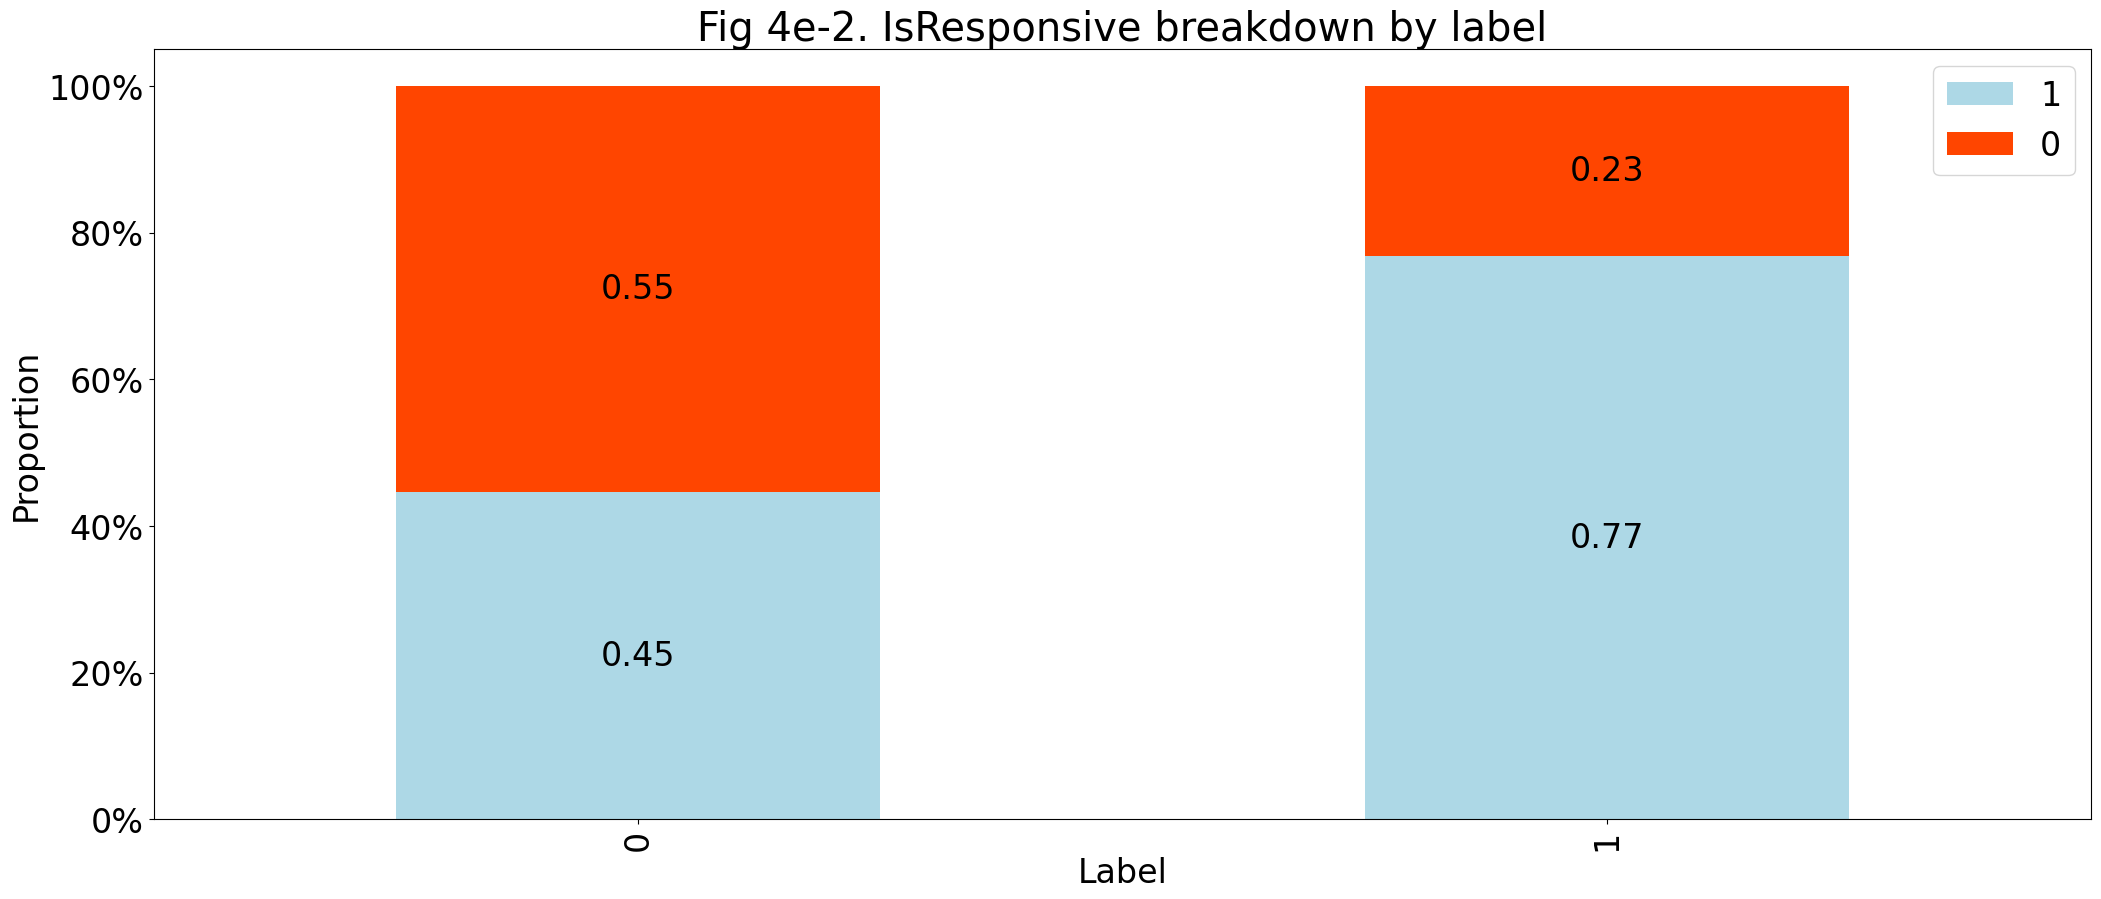

In [86]:
# Relationship between IsResponsive and label

df_4e1 = reformat_df(df, "label", "IsResponsive", [1, 0])
ax_4e1 = df_4e1.plot(kind='bar', stacked=True, color = ["lightblue", "orangered"])
plt.title('Fig 4e-2. IsResponsive breakdown by label')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend()

for c in ax_4e1.containers:
    ax_4e1.bar_label(c, label_type='center',  fmt= '%.2f')

plt.show()

In [158]:
# Chi-sqared test on NoOfURLRedirect and label
summary, detail = feature_diagnostic(df, "label", "IsResponsive")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  IsResponsive
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  1.1570409122946362e-250
cramers_v :  0.33000802775740146
base_rate_tracker :  False
frac_categories_outside_lift_tol :  1.0
max_category_l1_dist :  0.42262425294004247
note :  
   category  class  count  p_y_given_cat  base_p  lift     n
0         0      0   2612           0.66    0.45  1.47  3952
1         0      1   1340           0.34    0.55  0.62  3952
2         1      0   2109           0.32    0.45  0.72  6548
3         1      1   4439           0.68    0.55  1.23  6548


**Observations**
- Fig 4d-2 suggests that the absence of a Robots.txt file is a statistically significant correlateion with a site being malicious; a much higher proportion of flagged malicious sites lack a robots.txt (85%) than in benign sites (64).
- The diagnostic test suggests that the presence and absence of Robots is likely a robust and stable predictor for the label, with a large association (Cramer's V ~ 0.24) and significant lift provided by both categories of Robots. In other words, both 1 and 0 values of Robots will change the distribution significantly from baseline.   
- One possible explanation is that creators of malicious sites don't bother generating robots.txt files since these files, which inform web crawlers what not to index, don't contribute to the main function of entrapping hapless victims

### 4f. Impact of Industry on Label

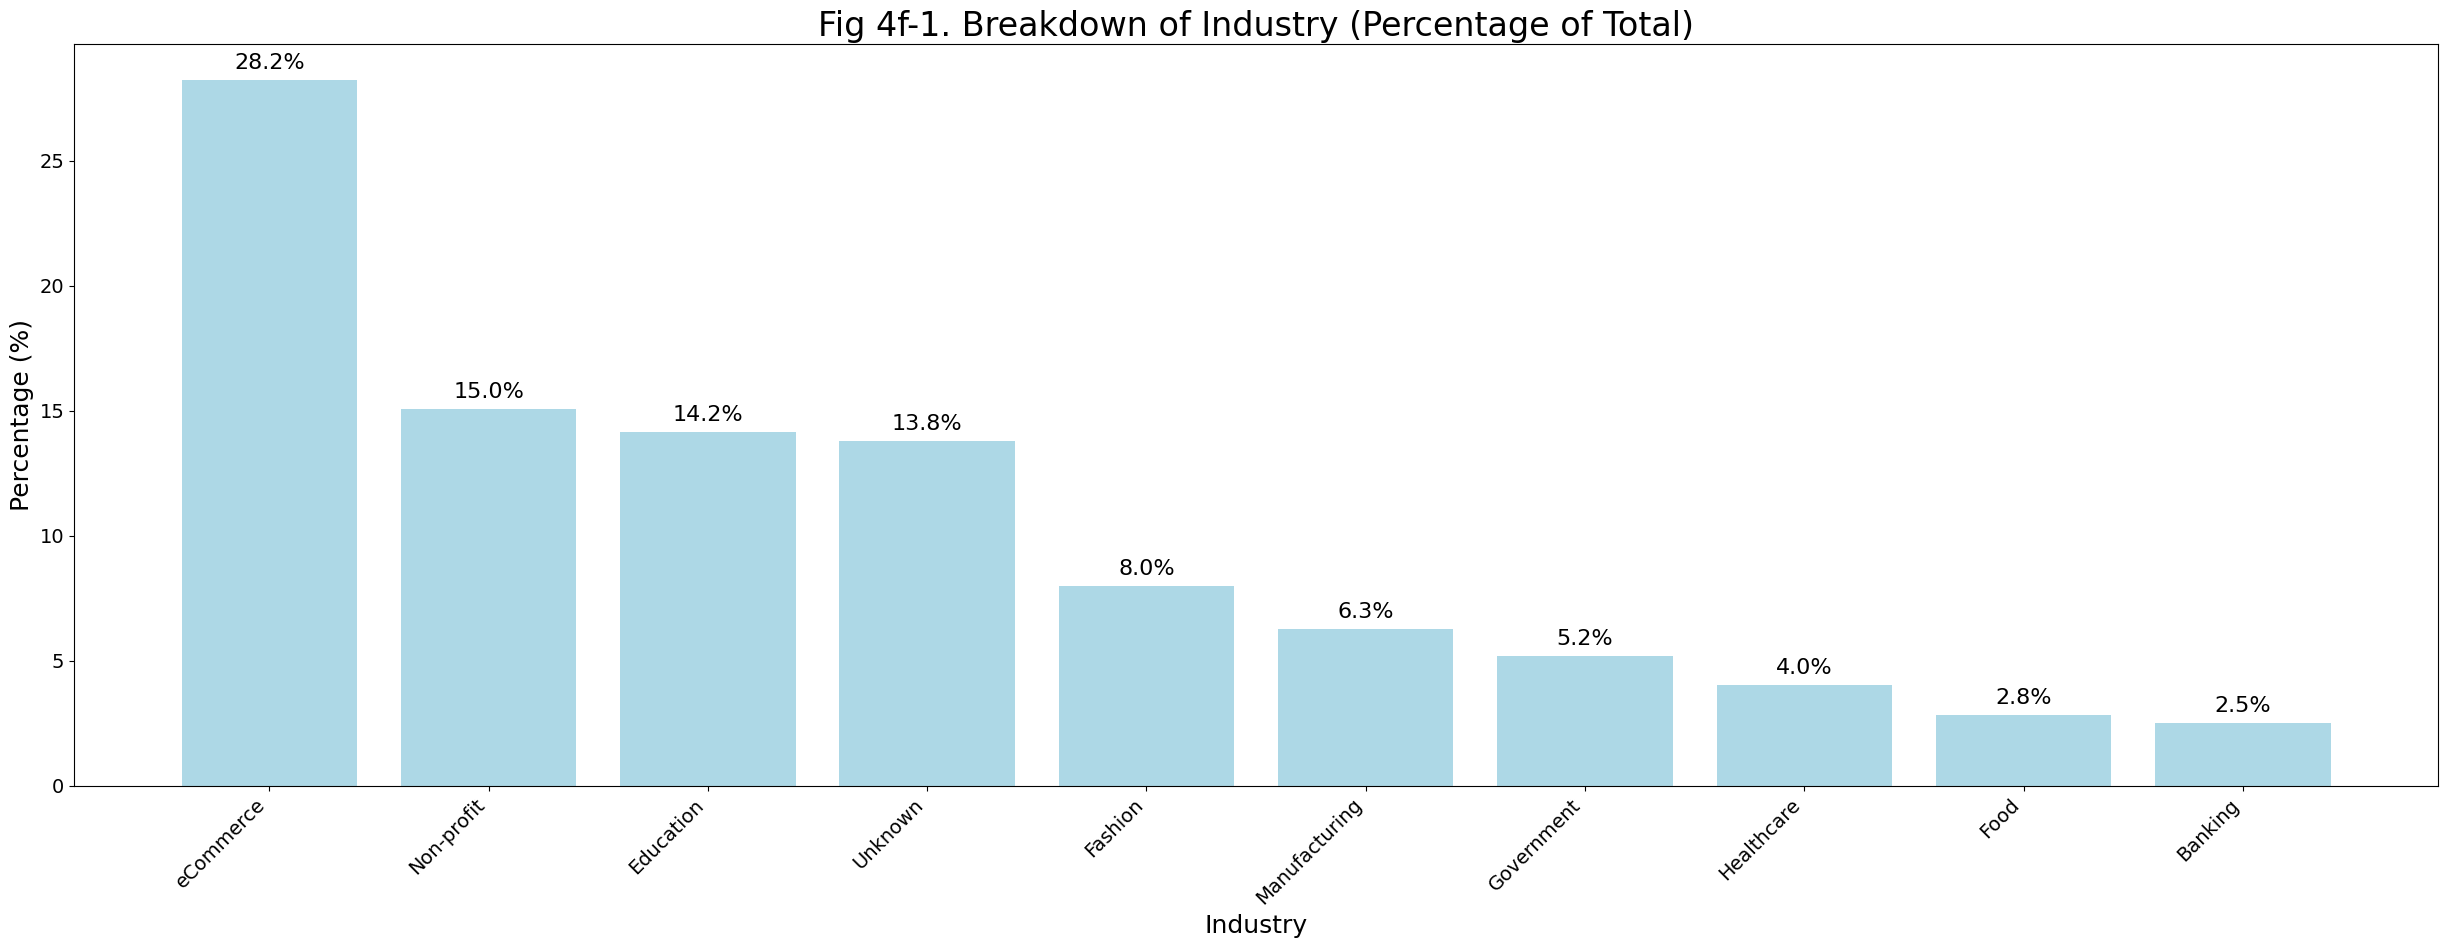

In [56]:
# Show Industry breakdown as percentage of total

plt.figure(figsize=(25,10))
plt.title("Fig 4f-1. Breakdown of Industry (Percentage of Total)", fontsize=24)
industry_counts = df.Industry.value_counts(normalize=True) * 100
bars = plt.bar(industry_counts.index, industry_counts.values, color='lightblue')
plt.ylabel('Percentage (%)', fontsize=18)
plt.xlabel('Industry', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(industry_counts.values)*0.01, f"{yval:.1f}%", ha='center', va='bottom', fontsize=16)

plt.tight_layout()
plt.show()

**Observations**
- The highest-represented industry type on the list (28%) is eCommerce, though a relatively high percentage (14%) are of unknown industries.

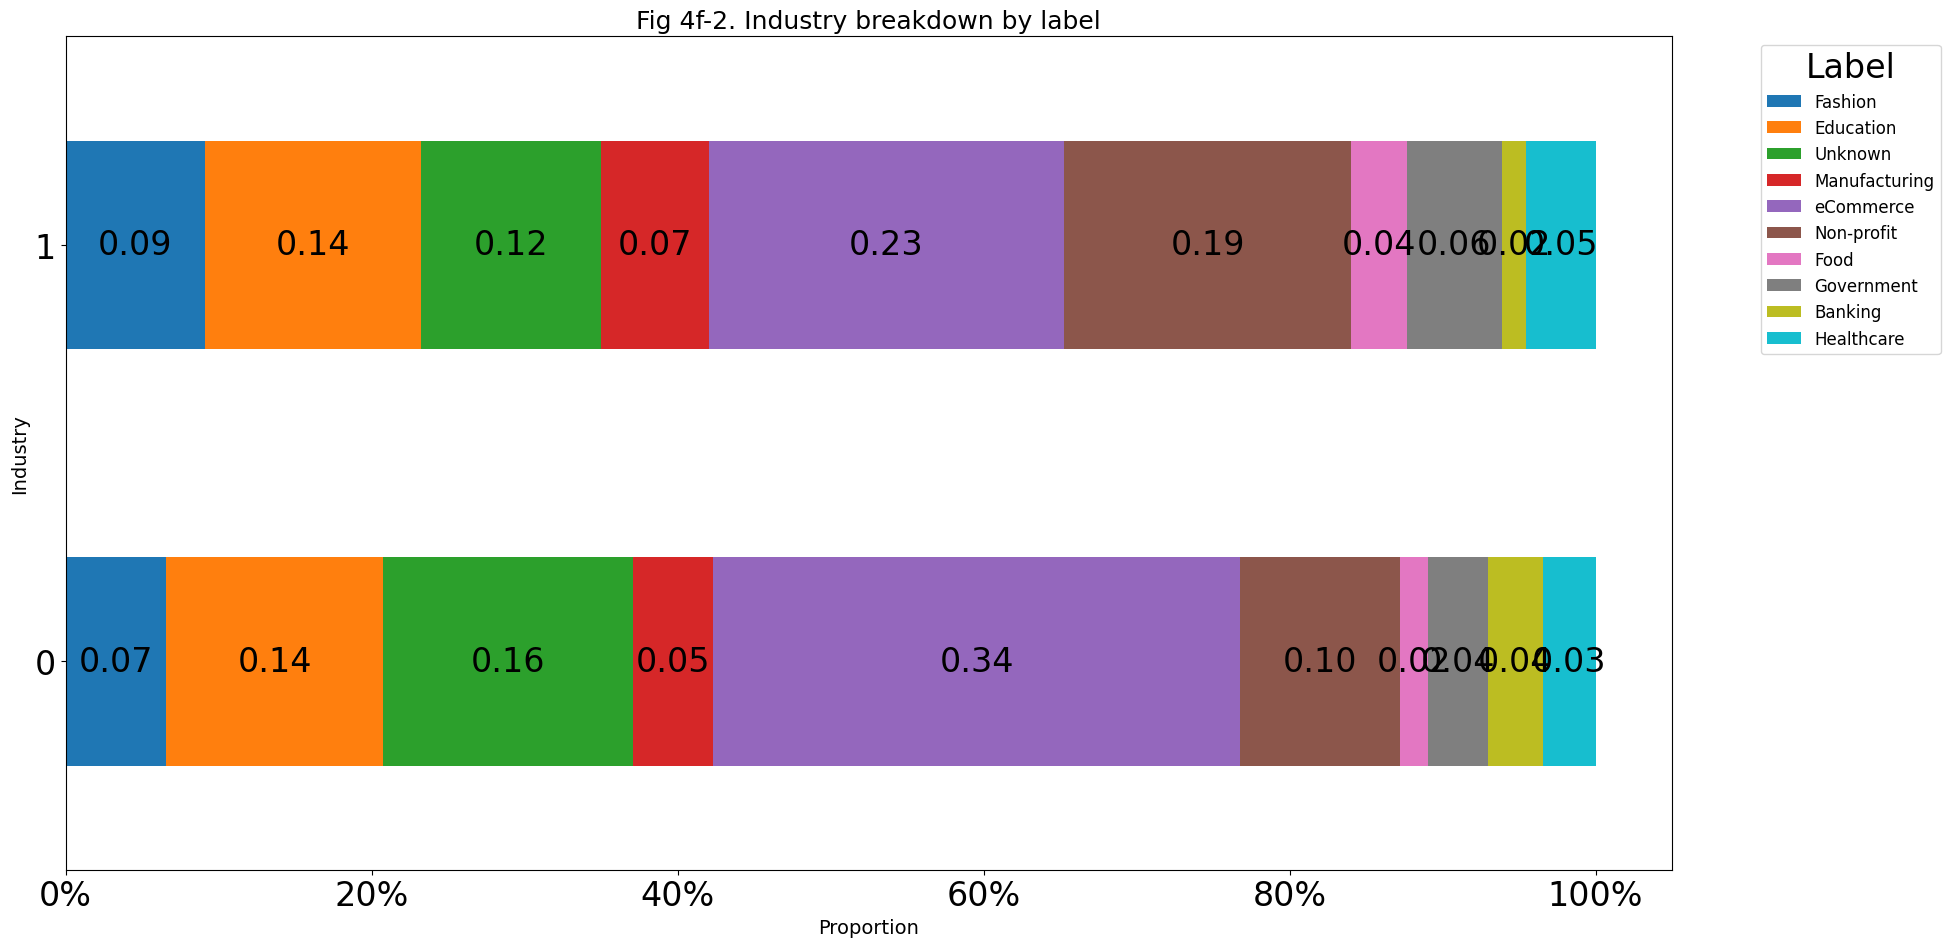

In [57]:
# Relationship between Industry and label (Horizontal Bar Chart)

df_4f1 = reformat_df(df, "label", "Industry", label_order = df.Industry.unique())
ax_4f1 = df_4f1.plot(kind='barh', stacked=True, figsize=(20, 10))
plt.title('Fig 4f-2. Industry breakdown by label', fontsize=18)
plt.ylabel('Industry', fontsize=14)
plt.xlabel('Proportion', fontsize=14)
plt.gca().xaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

for c in ax_4f1.containers:
    ax_4f1.bar_label(c, label_type='center', fmt='%.2f')

plt.tight_layout()
plt.show()

In [159]:
# Chi-sqared test on NoOfURLRedirect and label
summary, detail = feature_diagnostic(df, "label", "Industry")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  Industry
total_n :  10500
all_above_min_expected :  True
n_categories :  10
n_categories_used :  10
kept_categories :  ['Banking' 'Education' 'Fashion' 'Food' 'Government' 'Healthcare'
 'Manufacturing' 'Non-profit' 'Unknown' 'eCommerce']
unkept_categories :  []
n_classes :  2
chisq_p_value :  4.022585115410773e-83
cramers_v :  0.1980535647796761
base_rate_tracker :  False
frac_categories_outside_lift_tol :  0.9
max_category_l1_dist :  0.3886406926406926
note :  
         category  class  count  p_y_given_cat  base_p  lift     n
0         Banking      0    170           0.64    0.45  1.43   264
1         Banking      1     94           0.36    0.55  0.65   264
2       Education      0    670           0.45    0.45  1.00  1486
3       Education      1    816           0.55    0.55  1.00  1486
4         Fashion      0    311           0.37    0.45  0.82   839
5         Fashion      1    528           0.63    0.55  1.14   839
6            Food      0     87           0.29    0.4

**Observations**
- The chisq test shows overall significant 